<a href="https://colab.research.google.com/github/nurskurmanbekov/Road-Safety-Looking-to-the-Future/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network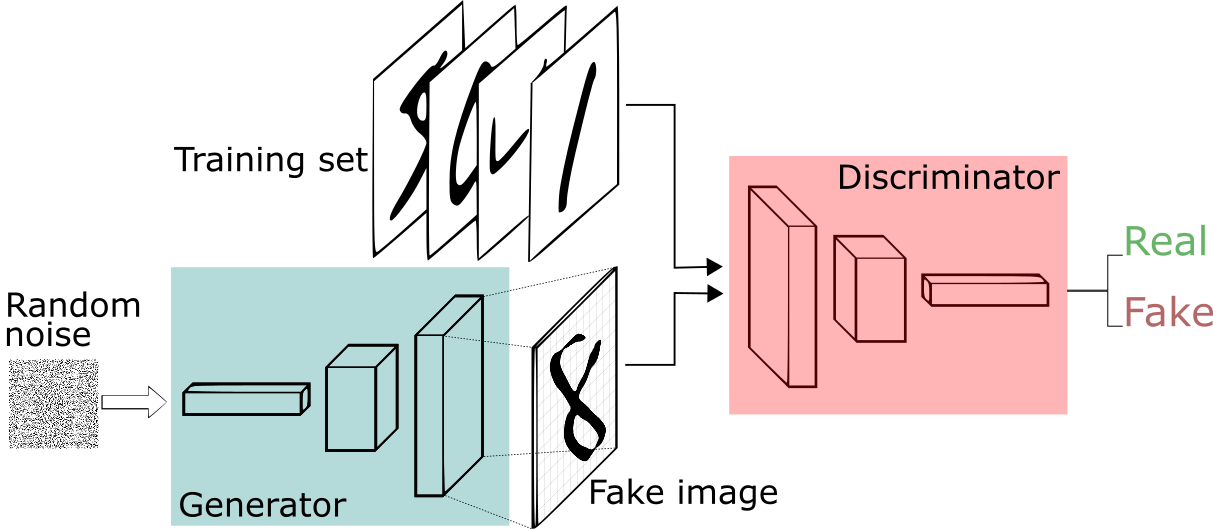

<b>Name: Nursultan </b>

<b>Surname: Kurmanbekov </b>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Configurations

In [ ]:
device = 'cuda' # image = image.to(device)
batch_size = 128 # trainloader , tarining loop
noise_dim =64 # generator model

# OPTIMIZER parameters
lr  = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 38

#Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms  as T

In [ ]:
train_augs = T.Compose([
                        T.RandomRotation((-20,+20)),
                        T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

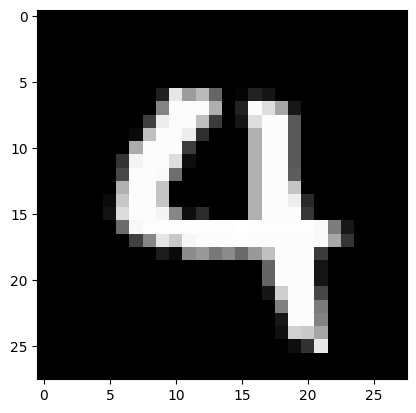

In [ ]:
image,  label = trainset[9040]

plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print('Total images present  in trainset are :', len(trainset))

Total images present  in trainset are : 60000


# Load Dataset into batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print('Total no. of batches  in trainloader : ' ,len(trainloader))

Total no. of batches  in trainloader :  469


In [ ]:
dataiter = iter(trainloader)
images, _ = dataiter.__next__()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

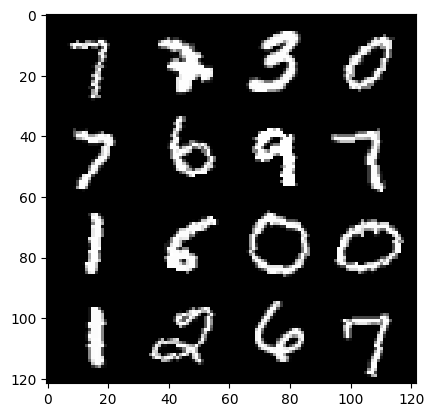

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = get_disc_block(1, 16, (3, 3), 2)
        self.block_2 = get_disc_block(16, 32, (5, 5), 2)
        self.block_3 = get_disc_block(32, 64, (5, 5), 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        return x5

In [ ]:
D = Discriminator()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D.to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Discriminator Network

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.ReLU()
    )

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2)
        self.block_2 = get_gen_block(256, 128, (4, 4), 1)
        self.block_3 = get_gen_block(128, 64, (3, 3), 2)
        self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, r_noise_vec):
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
              ReLU-2            [-1, 256, 3, 3]               0
   ConvTranspose2d-3            [-1, 128, 6, 6]         524,416
              ReLU-4            [-1, 128, 6, 6]               0
   ConvTranspose2d-5           [-1, 64, 13, 13]          73,792
              ReLU-6           [-1, 64, 13, 13]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 746,945
Trainable params: 746,945
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 2.85
Estimated Total Size (MB): 3.13
----------------------------------------------------------------


In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  groun_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, )
  return loss
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  groun_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, )
  return loss

In [ ]:
D_opt =torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt =torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _  in trainloader :
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_opt.step()

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device )
    fake_img =

In [ ]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)